# MDP with Unmeasured Confounders

The model we are using:  
Medical Treatment model as defined in Appendix A in https://causalai.net/mdp-causal.pdf

In [80]:
def physicains_policy(St, Mt, Et):
    return (St+Mt+Et) % 2

In [81]:
import numpy as np
# probability_yt_is_1 is a 4 dimensional array
# format: probability_yt_is_1[St][Mt][Et][Xt] is P(Yt = 1 | Xt, St, Mt, Et)
probability_yt_is_1 = np.zeros((2,2,2,2))
probability_yt_is_1[0][0][0][0] = 0.2
probability_yt_is_1[0][0][0][1] = 0.9
probability_yt_is_1[0][0][1][0] = 0.9
probability_yt_is_1[0][0][1][1] = 0.2
probability_yt_is_1[0][1][0][0] = 0.8
probability_yt_is_1[0][1][0][1] = 0.3
probability_yt_is_1[0][1][1][0] = 0.3
probability_yt_is_1[0][1][1][1] = 0.8

probability_yt_is_1[1][0][0][0] = 0.7
probability_yt_is_1[1][0][0][1] = 0.2
probability_yt_is_1[1][0][1][0] = 0.2
probability_yt_is_1[1][0][1][1] = 0.7
probability_yt_is_1[1][1][0][0] = 0.1
probability_yt_is_1[1][1][0][1] = 0.8
probability_yt_is_1[1][1][1][0] = 0.8
probability_yt_is_1[1][1][1][1] = 0.1

In [82]:
# transition_prob is a 2 dimensional array
# format: transition_prob[Xt][St] = P(St+1 = 0 | St, Xt)
transition_prob = np.zeros((2,2))
transition_prob[0][0] = 0.9
transition_prob[0][1] = 0.3
transition_prob[1][0] = 0.7
transition_prob[1][1] = 0.8

In [83]:
def get_Yt(St, Mt, Et, Xt):
    u = np.random.rand()
    if u < probability_yt_is_1[St][Mt][Et][Xt]:
        return 1
    return 0

In [84]:
def get_next_state(St, Xt):
    u = np.random.rand()
    if u < transition_prob[Xt][St]:
        return 0
    return 1

# Generate data from our model

In [85]:
import pandas as pd

data_df = pd.DataFrame()

In [86]:
def generate_single_trajectory(patient_id):
    global data_df
    St = np.random.randint(2)
    for t in range(100):
        Mt, Et = np.random.randint(2), np.random.randint(2)
        Xt = physicains_policy(St, Mt, Et)
        Yt = get_Yt(St, Mt, Et, Xt)
        data_df = data_df.append({'pt_id': patient_id,'t': t, 'St': St, 'Mt': Mt, 'Et': Et, 'Xt': Xt, 'Yt': Yt}, ignore_index=True)
        St = get_next_state(St, Xt)

In [92]:
for patient_id in range(18242):
    if patient_id % 1000 == 0:
        print("Iteration number: ", patient_id)
    generate_single_trajectory(patient_id)

In [94]:
data_df.to_csv('/Users/faaiz/MDPUC/data.csv')

In [95]:
data_df.head()

,Et,Mt,St,Xt,Yt,pt_id,t
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,2.0
3,1.0,0.0,0.0,1.0,1.0,0.0,3.0
4,1.0,0.0,0.0,1.0,0.0,0.0,4.0


In [338]:
############## Define parameters #################

n_states = 2
n_actions = 2

### Divide the data into training and testing sets

In [109]:
patients = data_df['pt_id'].unique()
training = patients[np.random.randint(5, size = (len(patients))) != 4]
testing = patients[np.random.randint(5, size = (len(patients))) == 4]

train_data = data_df.loc[data_df['pt_id'].isin(training)].reset_index()
test_data = data_df.loc[data_df['pt_id'].isin(testing)].reset_index()

# Finding optimal policy assuming the confounders $E_{t}$ and $M_{t}$ are not measured
The states of MDP are $S_t$, actions are $X_t$ and rewards are $Y_t$
### 1. Estimating the Transition matrix T(S,S',A) and Reward matrix R(S,A)

In [312]:
from util_functions import *

transition, R, sums = compute_transitions_and_rewards(train_data, n_states=2, n_actions=2)

Sanity Check to make sure transition matrix estimate is accurate

In [336]:
transition

array([[[0.89987782, 0.70066325],
        [0.10012218, 0.29933675]],

       [[0.29994861, 0.80034186],
        [0.70005139, 0.19965814]]])

Estimate physician's policy from data

In [337]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

### 2. Do policy iteration

In [339]:
from mdp_utils import *

gamma = 0.99
V, policy, i, Qon = mdp_policy_iteration_with_Q(transition, R, gamma, np.ones(n_states))
OptimalAction = Qon.argmax(axis=1) # deterministic

In [296]:
Qon

array([[23.8969691 , 23.87507313],
       [23.73126535, 23.78559731]])

In [342]:
V

array([23.8969691 , 23.78559731])

#### Compare this with policy iteration on complete model (with no missing confounders)

In [343]:
complete_model_train = train_data.copy()
complete_model_train['St'] = complete_model_train['Et'] + 2*complete_model_train['Mt'] + 4*complete_model_train['St']
complete_model_train.drop(columns=['Et', 'Mt'], inplace=True)
complete_model_train.head()


,index,St,Xt,Yt,pt_id,t
0,0,1.0,1.0,0.0,0.0,0.0
1,1,2.0,1.0,0.0,0.0,1.0
2,2,2.0,1.0,1.0,0.0,2.0
3,3,1.0,1.0,1.0,0.0,3.0
4,4,1.0,1.0,0.0,0.0,4.0


In [344]:
n_states=8
transition_complete, R_complete, sums_complete = compute_transitions_and_rewards(complete_model_train, n_states=8, n_actions=2)
V_complete, policy_complete, i, Qon_complete = mdp_policy_iteration_with_Q(transition_complete, R_complete, gamma, np.ones(n_states))


In [353]:
s = complete_model_train.loc[complete_model_train['St']==0]
(s.loc[s['Xt']==0, 'Yt']==1).mean()

0.19934449782247565

In [347]:
policy_complete

array([0, 1, 1, 0, 1, 0, 0, 1])

In [346]:
Qon_complete

array([[22.34089561,  0.        ],
       [ 0.        , 22.31504513],
       [ 0.        , 22.4160442 ],
       [22.44241671,  0.        ],
       [ 0.        , 22.32816165],
       [22.26408041,  0.        ],
       [22.16243285,  0.        ],
       [ 0.        , 22.22776814]])

In [345]:
V_complete

array([22.34089561, 22.31504513, 22.4160442 , 22.44241671, 22.32816165,
       22.26408041, 22.16243285, 22.22776814])

### 3. Off policy evaluation on Test dataset

In [308]:
from util_functions import *

OPevaluation_data, bootwis = evaluate_policy(test_data, OptimalAction, n_states=2, n_actions=2, gamma=0.99, n_iters=750)


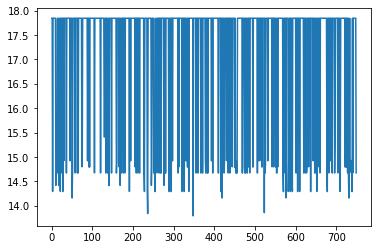

In [311]:
import matplotlib.pyplot as plt

plt.plot(bootwis)
plt.show()

# Calculating Actual value of the policy in a model with all confounders

We define a state variable $S'_t$ which contains information about all confounders

In [321]:
complete_model_test = test_data.copy()

In [322]:
complete_model_test['St'] = complete_model_test['Et'] + 2*complete_model_test['Mt'] + 4*complete_model_test['St']
complete_model_test.drop(columns=['Et', 'Mt'], inplace=True)
complete_model_test.head()

,index,St,Xt,Yt,pt_id,t
0,0,1.0,1.0,0.0,0.0,0.0
1,1,2.0,1.0,0.0,0.0,1.0
2,2,2.0,1.0,1.0,0.0,2.0
3,3,1.0,1.0,1.0,0.0,3.0
4,4,1.0,1.0,0.0,0.0,4.0


In [302]:
def mapDeterministicPolicyToNewStateSpace(policy):
    mapped_policy = np.zeros(8)
    for i in range(4):
        mapped_policy[i] = policy[0]
    for i in range(4,8):
        mapped_policy[i] = policy[1]
    return mapped_policy

In [303]:
newOptimalPolicy = mapDeterministicPolicyToNewStateSpace(OptimalAction)

In [304]:
from util_functions import *

complete_model_test_p1, bootwis_actual = evaluate_policy(complete_model_test, newOptimalPolicy, n_states=8, n_actions=2, gamma=0.99, n_iters=750)


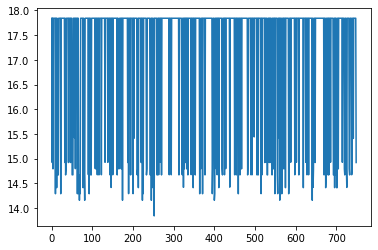

In [307]:
plt.plot(bootwis_actual)
plt.show()

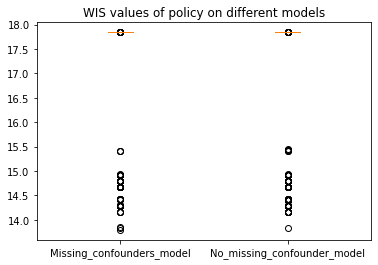

In [335]:
data = [bootwis, bootwis_actual]
fig, ax = plt.subplots()
ax.set_title('WIS values of policy on different models')
ax.boxplot(data)
plt.xticks([1,2],['Missing_confounders_model','No_missing_confounder_model'])
plt.show()

In [265]:
bootwis_actual.mean()

17.093170811295916

In [266]:
bootwis.mean()

17.066969832734127

# We now repeat the evaluation for policy $\pi$ defined by $\pi(S_t = 0) = 1$ and $\pi(S_t = 1) = 0$

#### 1. Policy evaluation with unmeasured confounders

In [319]:
policy = np.array([1,0])

OPevaluation_data_p2, bootwis_p2 = evaluate_policy(test_data, policy, n_states=2, n_actions=2, gamma=0.99, n_iters=100)


#### 2. Policy evaluation on complete model (with confounders $E_t$ and $M_t$ included)

In [323]:
mapped_policy = mapDeterministicPolicyToNewStateSpace(policy)

complete_model_test_p2, bootwis_actual_p2 = evaluate_policy(complete_model_test, mapped_policy, n_states=8, n_actions=2, gamma=0.99, n_iters=100)


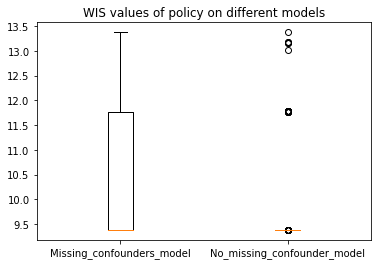

In [334]:
data = [bootwis_p2, bootwis_actual_p2]
fig, ax = plt.subplots()
ax.set_title('WIS values of policy on different models')
ax.boxplot(data)
plt.xticks([1,2],['Missing_confounders_model','No_missing_confounder_model'])
plt.show()